# Enhanced Stock Prediction Model Training

This notebook implements a complete pipeline for stock prediction model training with:
- Data gathering and loading
- Data cleaning and preprocessing  
- Correlation analysis and heatmap visualization
- Feature selection based on correlation
- Model training with Bayesian optimization

# 1. Imports

In [435]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 8)

# 2. Configuration

In [436]:
import os

BASE_DIR = os.path.dirname(os.getcwd())
MODELS_DIR = os.path.join(BASE_DIR, "models")
SCALER_PATH = os.path.join(MODELS_DIR, "scaler.pkl")
MODEL_PATH = os.path.join(MODELS_DIR, "tensor.pt")
FEATURE_INFO_PATH = os.path.join(MODELS_DIR, "feature_info.json")

# Ensure models directory exists
os.makedirs(MODELS_DIR, exist_ok=True)

print(f"Working directory: {os.getcwd()}")
print(f"Base directory (stockbot): {BASE_DIR}")
print(f"Models directory: {MODELS_DIR}")

Working directory: C:\Users\MIS\Lambton\Term3\software-tool-peter\stockbot\train
Base directory (stockbot): C:\Users\MIS\Lambton\Term3\software-tool-peter\stockbot
Models directory: C:\Users\MIS\Lambton\Term3\software-tool-peter\stockbot\models


# 3. Data Gathering And Loading

In [437]:
# Load the enhanced dataset with technical indicators
try:
    df = pd.read_csv("updated_stock_features.csv")
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Display basic info
    print(df.head())
    
except FileNotFoundError:
    print("Dataset not found!")
    raise

Dataset shape: (912, 36)
Columns: ['close_price', 'open_price', 'high_price', 'low_price', 'volume', 'daily_return', 'weekly_return', 'price_momentum_3d', 'sma_3', 'sma_7', 'ema_3', 'price_to_sma3', 'price_to_sma7', 'price_volatility', 'high_low_ratio', 'close_to_high_ratio', 'close_to_low_ratio', 'volume_sma', 'volume_ratio', 'price_volume', 'rsi', 'macd', 'bb_position', 'distance_to_high', 'distance_to_low', 'trend_slope', 'gap_up', 'gap_down', 'intraday_return', 'intraday_high_reach', 'intraday_low_reach', 'bullish_days_ratio', 'vpt', 'ticker', 'date', 'label']
   close_price  open_price  high_price   low_price    volume  daily_return  \
0   232.718613  234.185076  235.551775  231.910564  39435300     -0.004778   
1   237.297562  234.075339  238.384950  233.865838  39832000      0.019676   
2   227.710693  236.778830  237.437230  227.481251  71759100     -0.040400   
3   229.426559  231.561409  231.730998  227.930169  68488300      0.007535   
4   222.104218  223.460945  223.879933 

# 4. Data Cleaning And Preprocessing

In [438]:
# Separate features and labels
feature_columns = [col for col in df.columns if col not in ['ticker', 'date', 'label']]
X = df[feature_columns].values
y = df['label'].values

print(f"Feature matrix shape: {X.shape}")

# Convert labels to numeric
label_map = {'SELL': 0, 'HOLD': 1, 'BUY': 2}
y_numeric = np.array([label_map[label] for label in y])

print(f"\nLabel conversion:")
print(f"SELL=0, HOLD=1, BUY=2")
print(f"Numeric label distribution: {pd.Series(y_numeric).value_counts().sort_index()}")

# Check for data quality issues
nan_count = np.isnan(X).sum()
inf_count = np.isinf(X).sum()

print(f"\nData quality check:")
print(f"NaN values: {nan_count}")
print(f"Infinite values: {inf_count}")

# Clean data if necessary
if nan_count > 0 or inf_count > 0:
    print("Found problematic values, cleaning...")
    X = np.nan_to_num(X, nan=0, posinf=0, neginf=0)

Feature matrix shape: (912, 33)

Label conversion:
SELL=0, HOLD=1, BUY=2
Numeric label distribution: 0    158
1    580
2    174
Name: count, dtype: int64

Data quality check:
NaN values: 0
Infinite values: 0


# 5. Correlation Heatmap Visualization

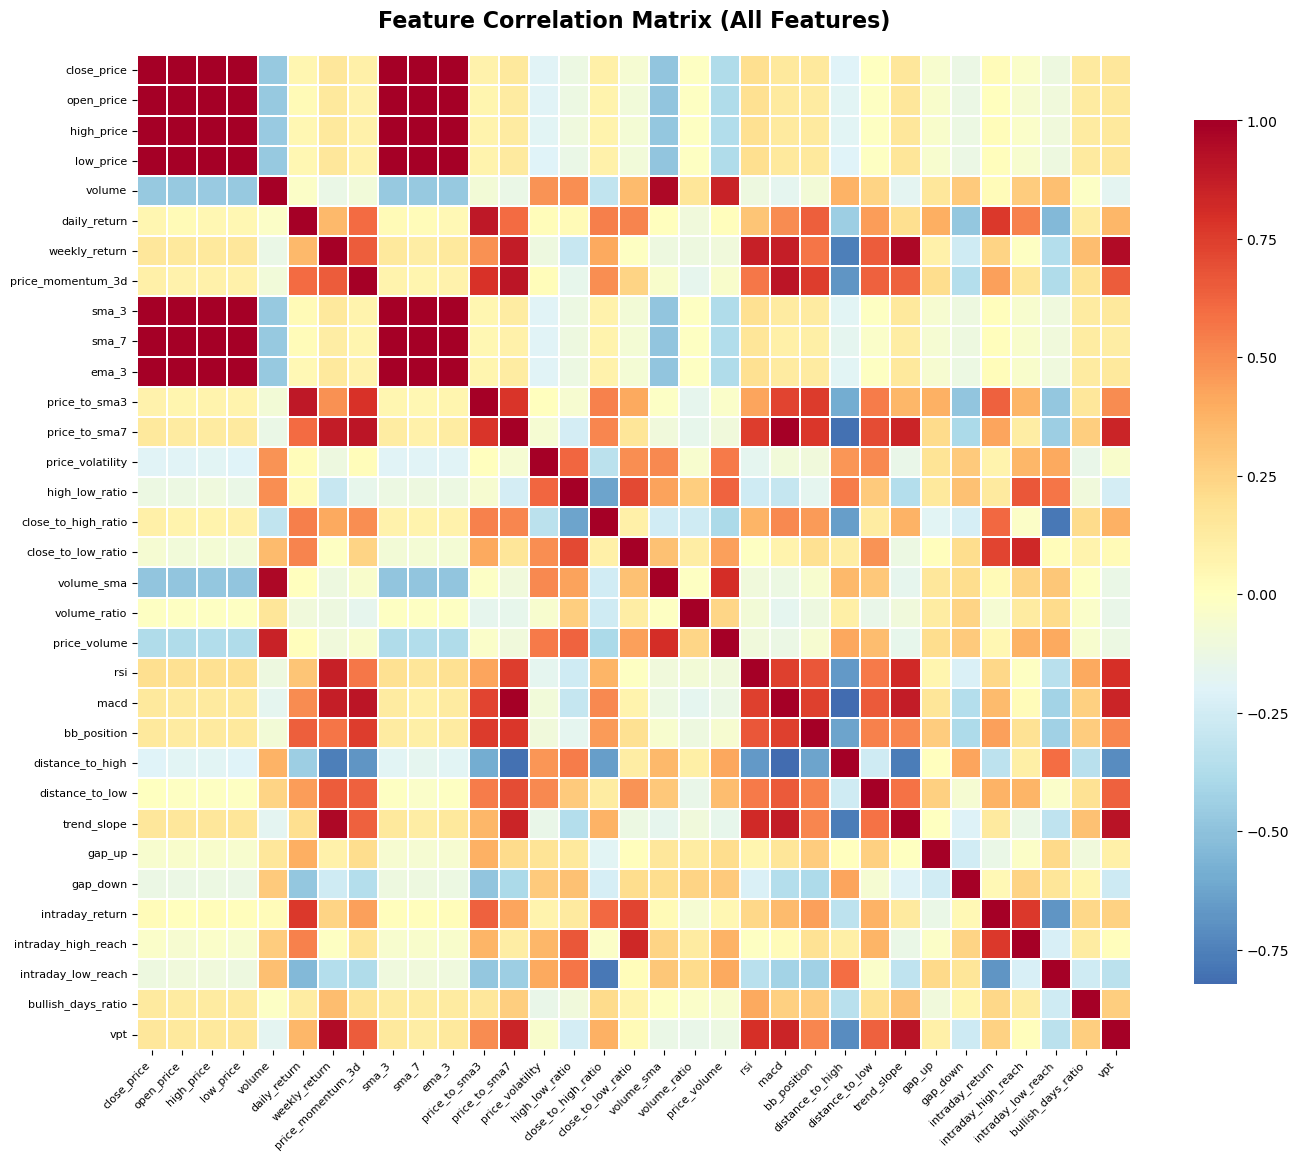

Found 28 highly correlated pairs (|correlation| > 0.9)


In [439]:
# Create correlation matrix
correlation_matrix = df[feature_columns].corr()

# Create the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, 
            cmap='RdYlBu_r',
            center=0,
            square=True,
            linewidths=0.1,
            cbar_kws={"shrink": .8})

plt.title('Feature Correlation Matrix (All Features)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

high_corr_pairs = []
correlation_threshold = 0.9

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = abs(correlation_matrix.iloc[i, j])
        if corr_value > correlation_threshold:
            high_corr_pairs.append({
                'feature1': correlation_matrix.columns[i],
                'feature2': correlation_matrix.columns[j], 
                'correlation': correlation_matrix.iloc[i, j]
            })

print(f"Found {len(high_corr_pairs)} highly correlated pairs (|correlation| > {correlation_threshold})")

# 6. Feature Selection Based On Correlation

In [440]:
def remove_highly_correlated_features(df, features, threshold=0.95):
    correlation_matrix = df[features].corr().abs()
    
    # Find features to remove
    features_to_remove = set()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if correlation_matrix.iloc[i, j] > threshold:
                # Remove the second feature (keep the first)
                features_to_remove.add(correlation_matrix.columns[j])
    
    # Create final feature set
    selected_features = [f for f in features if f not in features_to_remove]
    
    return selected_features, list(features_to_remove)

# Apply feature selection
correlation_threshold = 0.85
selected_features, removed_features = remove_highly_correlated_features(
    df, feature_columns, threshold=correlation_threshold
)

print(f"Original features: {len(feature_columns)}")
print(f"Features removed: {len(removed_features)}")
print(f"Features selected: {len(selected_features)}")

# Update feature matrix
X_selected = df[selected_features].values
print(f"\nUpdated feature matrix shape: {X_selected.shape}")

Original features: 33
Features removed: 14
Features selected: 19

Updated feature matrix shape: (912, 19)


# 7. Correlation Heatmap After Feature Selection

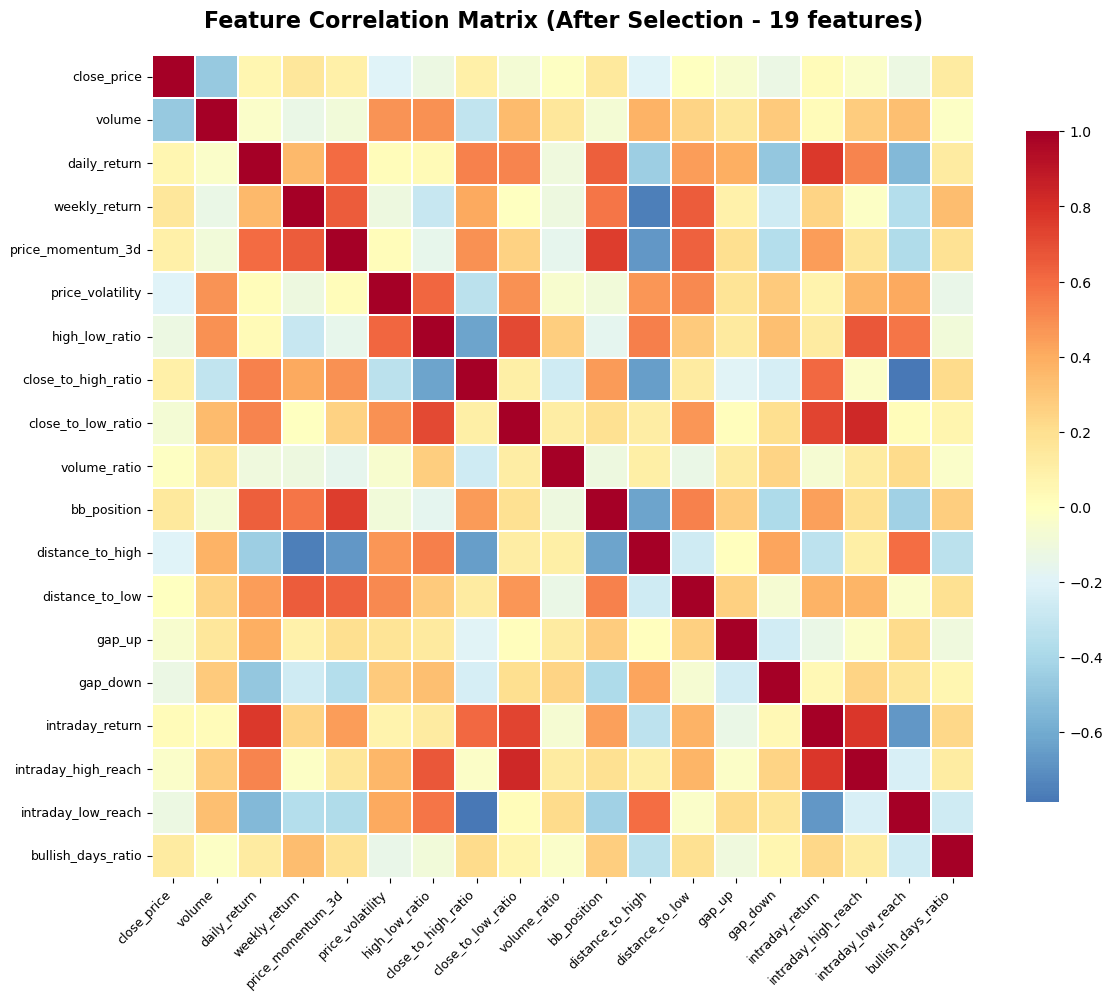

In [441]:
# Create correlation matrix for selected features
correlation_matrix_clean = df[selected_features].corr()

# Create the updated heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_clean, 
            cmap='RdYlBu_r',
            center=0,
            square=True,
            annot=False,
            linewidths=0.1,
            cbar_kws={"shrink": .8})

plt.title(f'Feature Correlation Matrix (After Selection - {len(selected_features)} features)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# Verify correlation improvement
high_corr_count = 0
max_corr = 0

for i in range(len(correlation_matrix_clean.columns)):
    for j in range(i+1, len(correlation_matrix_clean.columns)):
        corr_val = abs(correlation_matrix_clean.iloc[i, j])
        if corr_val > 0.8:
            high_corr_count += 1
        if corr_val > max_corr:
            max_corr = corr_val

# 8. Data Preparation For Model Training

In [442]:
# Use selected features
X = X_selected

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y_numeric, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_numeric
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

print(f"Training: {pd.Series(y_train).value_counts().sort_index()}")
print(f"Validation: {pd.Series(y_val).value_counts().sort_index()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

print(f"X_train: {X_train_tensor.shape}")
print(f"X_val: {X_val_tensor.shape}")
print(f"y_train: {y_train_tensor.shape}")
print(f"y_val: {y_val_tensor.shape}")

# Save scaler for later use
with open(SCALER_PATH, 'wb') as f:
    pickle.dump(scaler, f)

Training set: (729, 19)
Validation set: (183, 19)
Training: 0    126
1    464
2    139
Name: count, dtype: int64
Validation: 0     32
1    116
2     35
Name: count, dtype: int64
X_train: torch.Size([729, 19])
X_val: torch.Size([183, 19])
y_train: torch.Size([729])
y_val: torch.Size([183])


# 9. Model Definition

In [443]:
class EnhancedStockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, 
                 num_classes=3, dropout_rate=0.3):
        super(EnhancedStockPredictor, self).__init__()
        
        self.input_dim = input_dim
        
        # Layer normalization for input
        self.input_norm = nn.LayerNorm(input_dim)
        
        # Enhanced architecture with batch normalization and dropout
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc4 = nn.Linear(hidden_dim3, num_classes)
        
        # Activation functions
        self.leaky_relu = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        # Input normalization
        x = self.input_norm(x)
        
        # Hidden layers with batch norm and dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.fc4(x)
        
        return x

# Get input dimension from selected features
input_dim = len(selected_features)

# 10. Bayesian Optimization Training Function

In [444]:
def train_and_evaluate_model(lr, dropout):
    # Create model with current hyperparameters
    model = EnhancedStockPredictor(
        input_dim=input_dim, 
        dropout_rate=float(dropout)
    )
    
    # Setup training
    optimizer = torch.optim.Adam(model.parameters(), lr=float(lr), weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    num_epochs = 30
    model.train()
    
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_predictions = torch.argmax(val_outputs, dim=1)
        val_accuracy = (val_predictions == y_val_tensor).float().mean().item()
    
    return val_accuracy

# Define hyperparameter search space
param_bounds = {
    'lr': (1e-4, 1e-2),      # Learning rate range
    'dropout': (0.1, 0.5)    # Dropout rate range
}

print(f"Hyperparameter search space:")
print(f"Learning rate: {param_bounds['lr']}")
print(f"Dropout rate: {param_bounds['dropout']}")

Hyperparameter search space:
Learning rate: (0.0001, 0.01)
Dropout rate: (0.1, 0.5)


In [445]:
# 11. Bayesian Optimization Execution

In [446]:
# Initialize Bayesian optimizer
optimizer = BayesianOptimization(
    f=train_and_evaluate_model,
    pbounds=param_bounds,
    verbose=2,
    random_state=42
)

print("Starting Bayesian optimization.")
print()

# Run optimization
optimizer.maximize(
    init_points=3,    # Number of random exploration points
    n_iter=8         # Number of optimization iterations
)

# Get best parameters
best_params = optimizer.max['params']
best_score = optimizer.max['target']

print(f"\nBAYESIAN OPTIMIZATION COMPLETED!")
print(f"=" * 60)
print(f"Best validation accuracy: {best_score:.4f} ({best_score*100:.2f}%)")
print(f"Best hyperparameters:")
print(f"   Learning rate: {best_params['lr']:.6f}")
print(f"   Dropout rate: {best_params['dropout']:.3f}")
print(f"=" * 60)

Starting Bayesian optimization.

|   iter    |  target   |    lr     |  dropout  |
-------------------------------------------------
| 1         | 0.6229507 | 0.0038079 | 0.4802857 |
| 2         | 0.6120218 | 0.0073467 | 0.3394633 |
| 3         | 0.6010928 | 0.0016445 | 0.1623978 |
| 4         | 0.6229507 | 0.0097021 | 0.3916134 |
| 5         | 0.6120218 | 0.0097987 | 0.3914834 |
| 6         | 0.6120218 | 0.0099552 | 0.3926029 |
| 7         | 0.6338797 | 0.0036871 | 0.4803804 |
| 8         | 0.6120218 | 0.0051600 | 0.3557371 |
| 9         | 0.6174863 | 0.0036029 | 0.4803095 |
| 10        | 0.6229507 | 0.0034678 | 0.4802334 |
| 11        | 0.6229507 | 0.0041449 | 0.2983341 |

BAYESIAN OPTIMIZATION COMPLETED!
Best validation accuracy: 0.6339 (63.39%)
Best hyperparameters:
   Learning rate: 0.003687
   Dropout rate: 0.480


# 12. Final Model Training With Best Parameter

In [447]:
# Create final model with best hyperparameters
final_model = EnhancedStockPredictor(
    input_dim=input_dim, 
    dropout_rate=best_params['dropout']
)

# Setup training with best parameters
optimizer_final = torch.optim.Adam(
    final_model.parameters(), 
    lr=best_params['lr'], 
    weight_decay=1e-4
)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_final, mode='max', factor=0.5, patience=10
)

# Extended training with monitoring
num_epochs = 100
best_val_acc = 0.0
train_losses = []
val_accuracies = []

print(f"Training final model for {num_epochs} epochs...")

for epoch in range(num_epochs):
    # Training phase
    final_model.train()
    optimizer_final.zero_grad()
    
    train_outputs = final_model(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)
    
    train_loss.backward()
    optimizer_final.step()
    
    train_losses.append(train_loss.item())
    
    # Validation phase (every 10 epochs)
    if epoch % 10 == 0:
        final_model.eval()
        with torch.no_grad():
            val_outputs = final_model(X_val_tensor)
            val_predictions = torch.argmax(val_outputs, dim=1)
            val_acc = (val_predictions == y_val_tensor).float().mean().item()
            
            val_accuracies.append(val_acc)
            scheduler.step(val_acc)
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(final_model.state_dict(), MODEL_PATH)
            
            print(f"Epoch {epoch:3d}: Train Loss = {train_loss.item():.4f}, Val Acc = {val_acc:.4f}, Best = {best_val_acc:.4f}")

print(f"Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Best model saved to: {MODEL_PATH}")

# Get total number of parameters
total_params = sum(p.numel() for p in final_model.parameters())
print(f"Model parameters: {total_params:,}")

Training final model for 100 epochs...
Epoch   0: Train Loss = 1.1474, Val Acc = 0.5355, Best = 0.5355
Epoch  10: Train Loss = 0.8661, Val Acc = 0.5956, Best = 0.5956
Epoch  20: Train Loss = 0.8665, Val Acc = 0.6066, Best = 0.6066
Epoch  30: Train Loss = 0.8358, Val Acc = 0.6175, Best = 0.6175
Epoch  40: Train Loss = 0.8289, Val Acc = 0.6120, Best = 0.6175
Epoch  50: Train Loss = 0.8113, Val Acc = 0.6230, Best = 0.6230
Epoch  60: Train Loss = 0.7936, Val Acc = 0.6339, Best = 0.6339
Epoch  70: Train Loss = 0.7895, Val Acc = 0.6284, Best = 0.6339
Epoch  80: Train Loss = 0.7843, Val Acc = 0.6175, Best = 0.6339
Epoch  90: Train Loss = 0.7612, Val Acc = 0.6175, Best = 0.6339
Best validation accuracy: 0.6339 (63.39%)
Best model saved to: C:\Users\MIS\Lambton\Term3\software-tool-peter\stockbot\models\tensor.pt
Model parameters: 13,481


In [448]:
# 13. Model Evaluation And Visualization

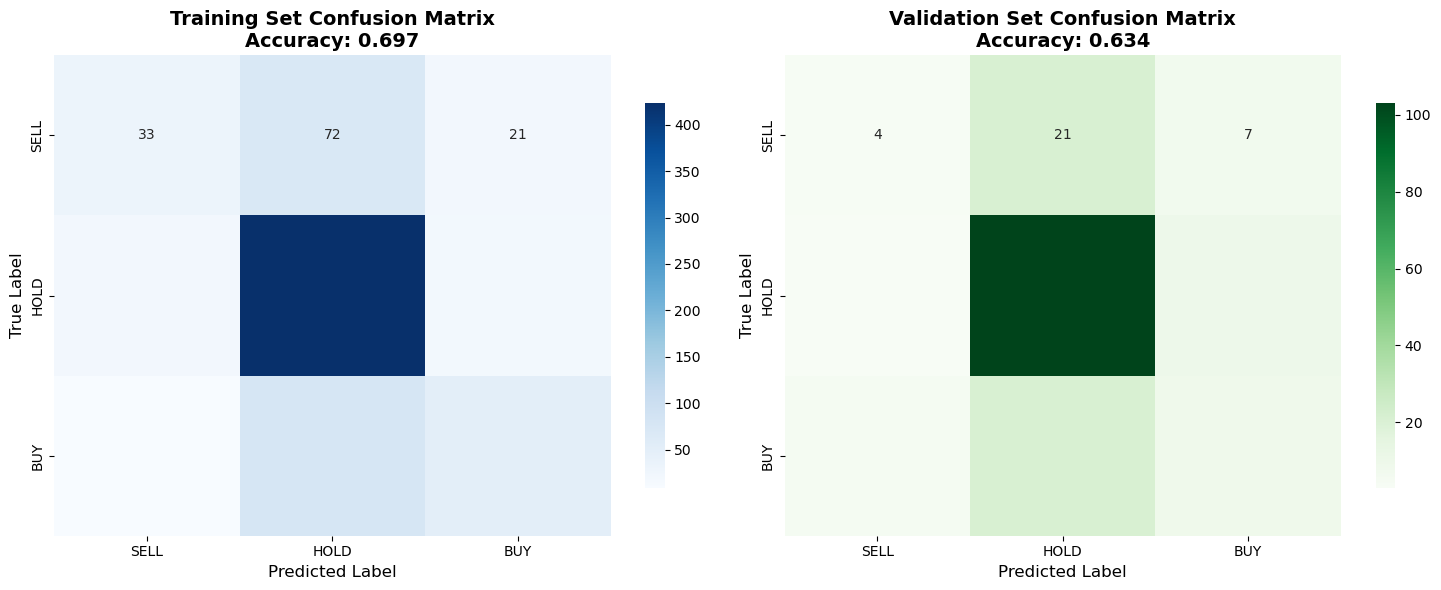

Validation Set Classification Report:
              precision    recall  f1-score   support

        SELL       0.33      0.12      0.18        32
        HOLD       0.71      0.89      0.79       116
         BUY       0.35      0.26      0.30        35

    accuracy                           0.63       183
   macro avg       0.46      0.42      0.42       183
weighted avg       0.57      0.63      0.59       183

\FINAL METRICS:
Training Accuracy: 0.6968 (69.68%)
Validation Accuracy: 0.6339 (63.39%)
Validation Improvement: 30.39% over random


In [449]:
# Load best model and evaluate
final_model.load_state_dict(torch.load(MODEL_PATH))
final_model.eval()

with torch.no_grad():
    # Get predictions
    train_outputs = final_model(X_train_tensor)
    val_outputs = final_model(X_val_tensor)
    
    train_predictions = torch.argmax(train_outputs, dim=1).numpy()
    val_predictions = torch.argmax(val_outputs, dim=1).numpy()
    
    # Calculate accuracies
    train_accuracy = (train_predictions == y_train).mean()
    val_accuracy = (val_predictions == y_val).mean()

# Create confusion matrices
train_cm = confusion_matrix(y_train, train_predictions)
val_cm = confusion_matrix(y_val, val_predictions)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training confusion matrix
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['SELL', 'HOLD', 'BUY'],
            yticklabels=['SELL', 'HOLD', 'BUY'],
            ax=ax1, cbar_kws={"shrink": .8})
ax1.set_title(f'Training Set Confusion Matrix\nAccuracy: {train_accuracy:.3f}', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)

# Validation confusion matrix
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['SELL', 'HOLD', 'BUY'],
            yticklabels=['SELL', 'HOLD', 'BUY'],
            ax=ax2, cbar_kws={"shrink": .8})
ax2.set_title(f'Validation Set Confusion Matrix\nAccuracy: {val_accuracy:.3f}', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

# Classification report
print("Validation Set Classification Report:")
print(classification_report(y_val, val_predictions, 
                          target_names=['SELL', 'HOLD', 'BUY']))

print(f"\FINAL METRICS:")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Validation Improvement: {(val_accuracy - 0.33)*100:.2f}% over random")

In [450]:
# 14. Feature Importance Analysis


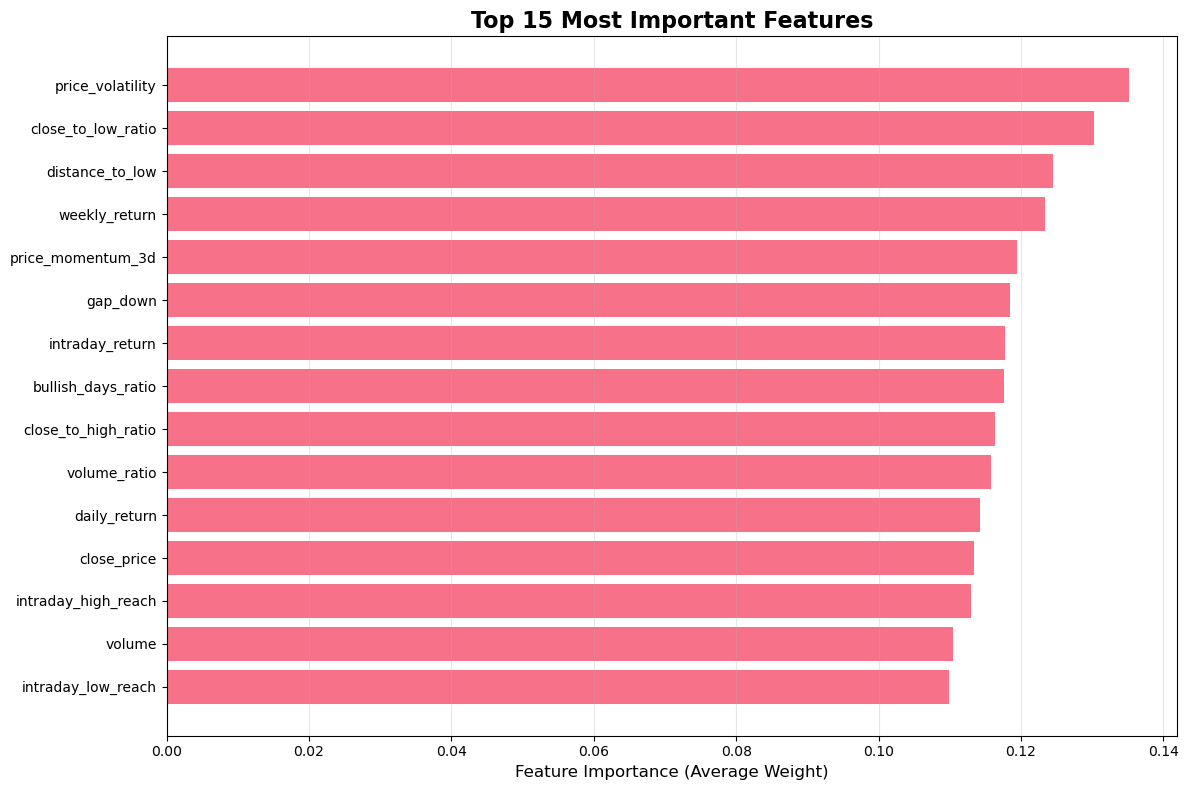


TOP 10 MOST IMPORTANT FEATURES:
 1. price_volatility          : 0.1352
 2. close_to_low_ratio        : 0.1302
 3. distance_to_low           : 0.1244
 4. weekly_return             : 0.1234
 5. price_momentum_3d         : 0.1195
 6. gap_down                  : 0.1185
 7. intraday_return           : 0.1178
 8. bullish_days_ratio        : 0.1177
 9. close_to_high_ratio       : 0.1163
10. volume_ratio              : 0.1158

FEATURE IMPORTANCE STATISTICS:
Mean importance: 0.1162
Std importance: 0.0077
Most important: price_volatility (0.1352)
Least important: high_low_ratio (0.1048)


In [451]:
# Extract feature importance from first layer weights
first_layer_weights = final_model.fc1.weight.data.numpy()
feature_importance = np.abs(first_layer_weights).mean(axis=0)

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)

plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=10)
plt.xlabel('Feature Importance (Average Weight)', fontsize=12)
plt.title('Top 15 Most Important Features', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print feature importance rankings
print("\nTOP 10 MOST IMPORTANT FEATURES:")
print("=" * 50)
for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:25s} : {row['Importance']:.4f}")

# Calculate feature importance statistics
print(f"\nFEATURE IMPORTANCE STATISTICS:")
print(f"Mean importance: {feature_importance.mean():.4f}")
print(f"Std importance: {feature_importance.std():.4f}")
print(f"Most important: {importance_df.iloc[0]['Feature']} ({importance_df.iloc[0]['Importance']:.4f})")
print(f"Least important: {importance_df.iloc[-1]['Feature']} ({importance_df.iloc[-1]['Importance']:.4f})")

# 15. Create Feature Info JSON File

In [452]:
# Check available variables
print(f"Selected features available: {'selected_features' in locals()}")
print(f"Feature columns available: {'feature_columns' in locals()}")
print(f"Input dimension: {len(selected_features) if 'selected_features' in locals() else 'N/A'}")

# Create basic feature information based on current training session
if 'selected_features' in locals() and 'feature_columns' in locals():
    
    # Create feature information for inference
    feature_info = {
        'selected_features': selected_features,
        'input_dim': len(selected_features),
        'original_features': len(feature_columns),
        'removed_features': removed_features if 'removed_features' in locals() else [],
        'model_params': {
            'hidden_dim1': 128,
            'hidden_dim2': 64,
            'hidden_dim3': 32,
            'dropout_rate': 0.3  # Default value, will be updated when model is trained
        },
        'correlation_threshold': 0.85,
        'dataset_info': {
            'shape': f"{df.shape}" if 'df' in locals() else "Unknown"
        }
    }
    
    # Save feature information to models directory
    import json
    with open(FEATURE_INFO_PATH, 'w') as f:
        json.dump(feature_info, f, indent=2)
    
    print(f"Feature info saved to: {FEATURE_INFO_PATH}")
    print(f"Model input dimension: {len(selected_features)}")
    print(f"Selected features: {len(selected_features)}")
    print(f"Removed features: {len(removed_features) if 'removed_features' in locals() else 0}")
    
    # Display the actual selected features
    print("\nSELECTED FEATURES:")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i:2d}. {feature}")
        
else:
    print("Required variables not available. Please run the feature selection cells first.")
    print("Available variables:", [var for var in locals().keys() if not var.startswith('_')])

Selected features available: True
Feature columns available: True
Input dimension: 19
Feature info saved to: C:\Users\MIS\Lambton\Term3\software-tool-peter\stockbot\models\feature_info.json
Model input dimension: 19
Selected features: 19
Removed features: 14

SELECTED FEATURES:
 1. close_price
 2. volume
 3. daily_return
 4. weekly_return
 5. price_momentum_3d
 6. price_volatility
 7. high_low_ratio
 8. close_to_high_ratio
 9. close_to_low_ratio
10. volume_ratio
11. bb_position
12. distance_to_high
13. distance_to_low
14. gap_up
15. gap_down
16. intraday_return
17. intraday_high_reach
18. intraday_low_reach
19. bullish_days_ratio
